# Introdução a Física Estatística e Computacional
## Teoria dos jogos - jogos evolucionários
### Luís Felipe Ramos Ferreira - 2019022553

In [15]:
import numpy as np
import numpy.typing as npt
import matplotlib.pyplot as plt
from matplotlib import colors
import matplotlib.patches as mpatches
import numba
import random
from tqdm import tqdm


In [16]:
# constants

COOPERATOR: np.int8 = 0
DEFECTOR: np.int8 = 1

L: np.int32 = 200
GRID_SIZE: np.int32 = L * L

RED = 1, 0, 0
GREEN = 0, 1, 0

COLORS: list[str] = [RED, GREEN]

In [17]:
@numba.jit(nopython=True)
def get_neighbours(grid_size: np.int64) -> npt.NDArray[np.int16]:
    L: np.int16 = int(np.sqrt(grid_size))
    neighbours = np.zeros((grid_size, 4), dtype=np.int16)
    for k in np.arange(grid_size):
        neighbours[k, 0] = k + 1
        if (k + 1) % L == 0:
            neighbours[k, 0] = k + 1 - L
        neighbours[k, 1] = k + L
        if k > (grid_size - L - 1):
            neighbours[k, 1] = k + L - grid_size
        neighbours[k, 2] = k - 1
        if k % L == 0:
            neighbours[k, 2] = k + L - 1
        neighbours[k, 3] = k - L
        if k < L:
            neighbours[k, 3] = k + grid_size - L
    return neighbours

In [18]:
def draw_grid(grid: npt.NDArray[np.int8]) -> None:
    cmap = colors.ListedColormap(colors=COLORS)
    grid = np.reshape(grid, newshape=(int(np.sqrt(grid.size)), int(np.sqrt(grid.size))))
    plt.figure(figsize=(8, 4))
    plt.title(f"Problema dos Prisioneiros")
    plt.xlabel(f"{grid.shape} grid")
    plt.xticks(np.arange(grid.shape[0] + 1), labels=[])
    plt.yticks(np.arange(grid.shape[0] + 1), labels=[])
    patches = [
        mpatches.Patch(color=COLORS[i], label=f"{'Cooperator' if i else 'Defector'}")
        for i in np.arange(2)
    ]
    plt.legend(handles=patches, bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.0)
    plt.imshow(
        grid,
        cmap=cmap,
        origin="lower",
        extent=(0, grid.shape[0], 0, grid.shape[0]),
        vmin=0,
        vmax=2,
    )


def plot_densities_per_time(densities: npt.NDArray[np.float64]) -> None:
    plt.title("Variação da densidade de cooperadores")
    plt.xlabel("Tempo (iterações)")
    plt.ylabel("Densidade de cooperadores")
    plt.plot(densities)
    plt.show()


def plot_densities_per_b(densities_per_b: npt.NDArray[np.float64], b_variation: np.float64 = 0.01, K: np.float64 = 0.2) -> None:
    plt.title(f"Variação da densidade de cooperadores após convergência\nK={K}")
    plt.xlabel("Valor de b")
    plt.xticks(ticks=np.arange(1, 2.1, 0.10))
    plt.ylabel("Densidade de cooperadores")
    plt.plot(np.arange(1, 2 + b_variation, b_variation), densities_per_b)
    plt.show()

In [19]:
@numba.jit(nopython=True)
def get_cooperators_densities(
    b: np.float32 = 1.5, K: np.float32 = 0.2, number_of_iterations: np.int64 = 10000000
) -> npt.NDArray[np.float64]:
    neighbours: npt.NDArray[np.int32] = get_neighbours(grid_size=GRID_SIZE)
    gain_matrix: npt.NDArray[np.int8] = np.array([[1.0, 0.0], [b, 0.0]])

    grid: npt.NDArray[np.int8] = np.zeros(shape=GRID_SIZE, dtype=np.int8)
    for m in range(GRID_SIZE):
        grid[m] = random.randint(0, 1)

    density_of_cooperators: np.float32 = 1 - np.count_nonzero(grid) / grid.size
    densities: np.float64 = np.zeros(shape=number_of_iterations, dtype=np.float64)
    densities[0] = density_of_cooperators
    for i in np.arange(number_of_iterations):
        # define random individual and it's gain
        random_individual: np.int32 = random.randint(0, GRID_SIZE)
        nature: np.int8 = grid[random_individual]
        neighbours_nature: npt.NDArray[np.int8] = np.append(
            grid[neighbours[random_individual]], nature
        )
        total_gain: np.float32 = np.sum(gain_matrix[nature][neighbours_nature])

        # chose random neighbours and get it's gain
        random_individual_neighbour: np.int8 = neighbours[random_individual][random.randint(0, 4)]
        nature = grid[random_individual_neighbour]
        neighbours_nature = np.append(
            grid[neighbours[random_individual_neighbour]], nature
        )
        total_neighbour_gain: np.float32 = np.sum(
            gain_matrix[nature][neighbours_nature]
        )
        W: np.float32 = 1 / (1 + np.exp((total_gain - total_neighbour_gain) / K))
        if random.random() < W:
            if grid[random_individual] != grid[random_individual_neighbour]:
                if grid[random_individual] == COOPERATOR:
                    density_of_cooperators -= 1 / grid.size
                else:
                    density_of_cooperators += 1 / grid.size
            grid[random_individual] = grid[random_individual_neighbour]
        densities[i] = density_of_cooperators
    return densities

@numba.jit(nopython=True, parallel=True)
def get_densities_per_b(b_variation: np.float64 = 0.01, K: np.float32 = 0.2) -> npt.NDArray[np.float64]:
    b_array: npt.NDArray[np.float64] = np.arange(1, 2 + b_variation, b_variation)
    densities_per_b: npt.NDArray[np.float64] = np.zeros(shape=b_array.size, dtype=np.float64)
    for i in numba.prange(b_array.size):
        density: np.float64 = get_cooperators_densities(b=b_array[i], K=K)[-1]
        densities_per_b[i] = density
    return densities_per_b

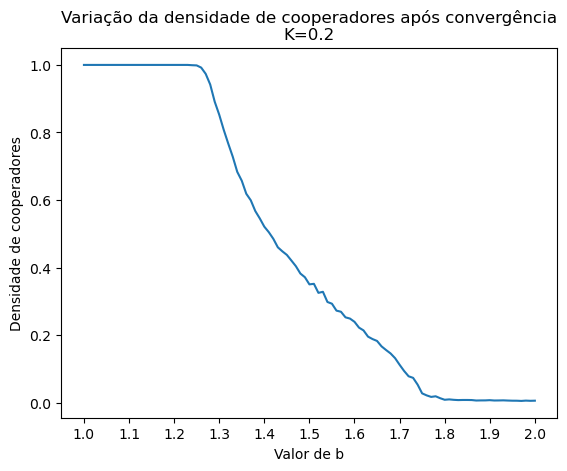

In [20]:
a = get_densities_per_b()
plot_densities_per_b(densities_per_b=a)

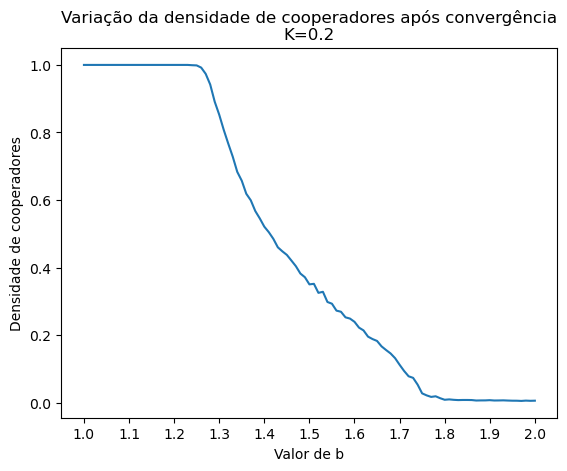

In [21]:
plot_densities_per_b(a)